In [1]:
import os
import sys
import time
import utils
import openpyxl

import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

import torch
import torchvision

import torchvision.utils as vutils
import torchvision.transforms as transforms

from torch import nn, optim, autograd
from dataclasses import dataclass

%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

pixeldict = {sitk.sitkUInt16: 'MET_USHORT'}

reader = sitk.ImageFileReader()     # reader for the input .mha files
reader.SetImageIO("MetaImageIO")

# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, cases_file, view, width=512, height=512):
        
        self.wb = openpyxl.load_workbook(os.path.join(root, cases_file))['All_delineated']        
        self.root = root        
        self.view = view
        self.width = width
        self.height = height

    def __len__(self):
        
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        
        list_all = []
        for cell_obj in self.wb['A'][1:] :
            list_all.append(cell_obj.value)
        
        return len(list_all)

    def __getitem__(self, idx):
        
        casedir = self.wb['A'][idx+1].value
#         print(casedir)
        
        patient_name = self.wb['A'][idx+1].value
        breast = self.wb['B'][idx+1].value
        
        if self.view == 'CC' :
            mask_exists = self.wb['C'][idx+1].value
        elif self.view == 'MLO' :
            mask_exists = self.wb['D'][idx+1].value
        else :
            raise ValueError('View is either "CC" or "MLO".')
            
        maskdir = os.path.join(self.root, 'FullDataset', patient_name, breast+'_'+self.view)
        
        # Collect the mask, low-energy image and recombined image of a CEM case
        if mask_exists > 0 and os.path.exists(maskdir) :
            print(maskdir)
        
            for filename in os.listdir(maskdir) :
                if "STRUCT" in filename and ".mha" in filename : 
#                     print(filename)
                    reader.SetFileName(os.path.join(maskdir, filename))
                    mask_image = reader.Execute()
                    mask_array = sitk.GetArrayFromImage(mask_image).astype(np.int8)
                    mask_array = torch.from_numpy(mask_array).type(torch.FloatTensor)
                    
#         print('mask', mask_array.shape)
        
        # Find nonzero region in mask
        mask_nz = np.nonzero(mask_array)        
        mask_nz = mask_nz.transpose(0,1)
        
        if len(mask_nz[0]) > 0 :

            xmin = min(mask_nz[0])
            xmax = max(mask_nz[0])
            ymin = min(mask_nz[1])
            ymax = max(mask_nz[1])
            # Define bounding box of nonzero region
            boxes = [[ymin, xmin, ymax, xmax]]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            xmiddle = (xmin+xmax)/2
            ymiddle = (ymin+ymax)/2
            xdist = xmax-xmin
            ydist = ymax-ymin
            # Get patch around nonzero region
            # If nonzero region is smaller than allowed size, surrounding tissue is saved as well
            cropped_region = mask_array[None,
                                        int(max(0,xmiddle-max(self.width/2,xdist/2))):min(mask_array.shape[0],int(xmiddle+max(self.width/2,xdist/2))),
                                        int(max(0,ymiddle-max(self.height/2,ydist/2))):min(mask_array.shape[1],int(ymiddle+max(self.height/2,ydist/2)))]   
    #         print('cropped', cropped_region.shape)
            # If nonzero region is larger than allowed size,
            # the patch equals the bounding box and is then resized to the allowed size
            resized_region = T.functional.resize(cropped_region, (self.height,self.width))
    #         print('resized', resized_region.shape)

            boxes_region = [[max(0,self.height/2-ydist/2),
                             max(0,self.width/2-xdist),
                             min(self.height,self.height/2+ydist/2),
                             min(self.width,self.width/2+xdist/2)]]

            boxes_region = torch.as_tensor(boxes_region, dtype=torch.float32)
            area_region = (boxes_region[:,3]-boxes_region[:,1]) * (boxes_region[:,2]-boxes_region[:,0])

            # Save label of benign and malignant cases
            labels = self.wb['F'][idx+1].value
            if isinstance(labels, str) and 'ben' in labels :
                labels = 0
            elif isinstance(labels, str) and 'mal' in labels :
                labels = 1
            labels = torch.as_tensor(labels, dtype=torch.int64)

            target = {}
            target["image_id"] = torch.tensor([idx+1])
            target["boxes"] = boxes
            target["boxes_region"] = boxes_region

            target["area"] = area
            target["area_region"] = area_region
            target["labels"] = labels

            return mask_array, resized_region, target
        
        else :
            print('Length of nonzero was 0')
            
            target = {}
            target["boxes_region"] = 4
            return mask_array, np.array((4,4)), target

In [4]:
inputdir =  '\\\\UZ\\Data\\lucmfr\\vol7\\sandbox\\CESM\\casesMaastricht'

true_data = CustomImageDataset(inputdir, 'Patient_TrainTest_MaskGAN.xlsx', 'CC')

In [5]:
true_dataloader = DataLoader(true_data, batch_size=2, shuffle=True, collate_fn=utils.collate_fn, drop_last=True)

In [6]:
len(true_data), len(true_dataloader)

(533, 266)

In [48]:
for idx in range(372,len(true_data)) :
    img, patch, target = true_data[idx]
    print(idx, img.shape, patch.shape, target['boxes_region'])

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0699\L_CC
372 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[215.5000, 168.0000, 296.5000, 300.0000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0700\L_CC
373 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[172.0000,  93.0000, 340.0000, 337.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0702\R_CC
374 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[209., 188., 303., 290.]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0703\L_CC
375 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[186.5000, 134.0000, 325.5000, 317.0000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0703\R_CC
376 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[182., 142., 330., 313.]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0704\L_CC
377 torch.Size([3062, 2394]) torch

418 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[110.5000,   0.0000, 401.5000, 386.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0777\L_CC
419 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[168.5000,  98.0000, 343.5000, 335.0000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0778\R_CC
420 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[226.0000, 205.0000, 286.0000, 281.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0779\R_CC
421 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[160., 108., 352., 330.]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0780\L_CC
422 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[173.0000, 101.0000, 339.0000, 333.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0782\R_CC
423 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[188.0000, 159.0000, 324.0000, 30

465 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[152., 114., 360., 327.]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0856\L_CC
466 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[227.5000, 198.0000, 284.5000, 285.0000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0860\L_CC
467 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[134.0000,  81.0000, 378.0000, 343.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0864\L_CC
468 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[187.5000, 138.0000, 324.5000, 315.0000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0866\L_CC
469 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[221., 162., 291., 303.]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0868\R_CC
470 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[209.5000, 165.0000, 302.5000, 301.5000]])
\\UZ\D

511 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[198.0000, 151.0000, 314.0000, 308.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0942\R_CC
512 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[221.5000, 178.0000, 290.5000, 295.0000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0943\L_CC
513 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[206.5000, 157.0000, 305.5000, 305.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0944\L_CC
514 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[201.5000, 167.0000, 310.5000, 300.5000]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0946\R_CC
Length of nonzero was 0
515 torch.Size([3062, 2394]) (2,) 4
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0947\L_CC
516 torch.Size([3062, 2394]) torch.Size([1, 512, 512]) tensor([[171.,  66., 341., 351.]])
\\UZ\Data\lucmfr\vol7\sandbox\CESM\c

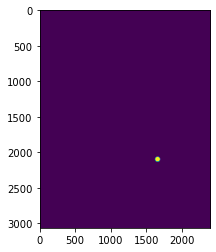

In [28]:
plt.imshow(img)

In [7]:
import matplotlib.pyplot as plt
pat_idx = 0
print(train_data[pat_idx][2]['image_id'], train_data[pat_idx][2]['boxes'], train_data[pat_idx][2]['boxes_region'])

fig, ax = plt.subplots(2,4, figsize=(10,5))

ax[0][0].imshow(train_data[pat_idx][0])
# ax[0][1].imshow(train_data[pat_idx][0][2])

enlarged_box = [int(train_data[pat_idx][2]['boxes'][0][1])-50,
                int(train_data[pat_idx][2]['boxes'][0][3])+50,
                int(train_data[pat_idx][2]['boxes'][0][0])-50,                
                int(train_data[pat_idx][2]['boxes'][0][2])+50]
print(enlarged_box)
ax[0][2].imshow(train_data[pat_idx][0][enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
# ax[0][3].imshow(train_data[pat_idx][0][2, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])


ax[1][0].imshow(train_data[pat_idx][1][0])
# ax[1][1].imshow(train_data[pat_idx][1][2])

enlarged_box = [int(train_data[pat_idx][2]['boxes_region'][0][1])-50,
                int(train_data[pat_idx][2]['boxes_region'][0][3])+50,
                int(train_data[pat_idx][2]['boxes_region'][0][0])-50,                
                int(train_data[pat_idx][2]['boxes_region'][0][2])+50]
print(enlarged_box)
ax[1][2].imshow(train_data[pat_idx][1][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
# ax[1][3].imshow(train_data[pat_idx][1][2, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

NameError: name 'train_data' is not defined

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    
    def __init__(self, nc, ngpu, nz, ngf):
        
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 64),
            nn.ReLU(True),
            
            # state size. (ngf*64) x 4 x 4
            nn.ConvTranspose2d(ngf * 64, ngf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            
            # state size. (ngf*32) x 8 x 4
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            
            # state size. (ngf*16) x 16 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 32 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 64 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 128 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 256 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 512 x 64
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    
    def __init__(self, ngpu, nc, ndf):
        
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            # input is (nc) x 512 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
                      
            # state size. (ndf) x 256 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 128 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 64 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
#             # state size. (ndf*4) x 32 x 8
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 16 x 8
#             nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 32),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 32, ndf * 64, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 64),
#             nn.LeakyReLU(0.2, inplace=True),            
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
generator = Generator(1, 1, 100, 64).cuda().float()
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

In [10]:
discriminator = Discriminator(1, 1, 64).cuda().float()
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(512, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

n_gpu = 1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))


In [12]:
adversarial_loss = nn.BCELoss() 

def generator_loss(G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
num_epochs = 5
D_loss_plot, G_loss_plot = [], []

G_params = [p for p in generator.parameters() if p.requires_grad]
D_params = [p for p in discriminator.parameters() if p.requires_grad]
G_optimizer = torch.optim.Adam(G_params, (2e-4)*n_gpu, betas=(0.5,0.999))
D_optimizer = torch.optim.Adam(D_params, (2e-4)*n_gpu, betas=(0.5,0.999))

list_test = torch.randn((5,4,1,512,512))

for epoch in range(1, num_epochs+1): 
    print('Epoch', epoch)
    
#     # Set up logger to save metrics and losses
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
#     header = f"Epoch: [{epoch}]"
#     print_freq = 10
  

    D_loss_list, G_loss_list = [], []
    
    true_iter = iter(true_dataloader)
    
    idx = 0
    while idx < len(true_dataloader) :
        print(idx)
        
        _, true_patches, _ = next(true_iter)
        true_img = torch.stack([patch.to(device) for patch in true_patches], dim=0)  
        true_img = true_img.to(device)
        
#     for true_img in list_test :
#         true_img = true_img.to(device)
        
        input_noise = torch.randn(true_img.shape[0],100,1,1, device=device)
      
        D_optimizer.zero_grad()       

        # ground truth labels real and fake
        real_target = torch.ones(true_img.shape[0], 1, 29, 29).to(device)
        fake_target = torch.zeros(true_img.shape[0], 1, 29, 29).to(device)
        
        # generator forward pass
        # from noise to gen mask
        generated_image = generator(input_noise)
        print('generated', generated_image.shape)
        
        # train discriminator with fake=generated masks
        discr_input_fake = torch.clone(generated_image)
        print('discr fake', discr_input_fake.shape)
        
        D_fake = discriminator(discr_input_fake.detach())  
        print('D fake', D_fake.shape)
        D_fake_loss = discriminator_loss(D_fake, fake_target)
        
        # train discriminator with real masks
        discr_input_real = torch.clone(true_img)
        print('discr real', discr_input_real.shape)
                                
        D_real = discriminator(discr_input_real)
        print('D real', D_real.shape)
        D_real_loss = discriminator_loss(D_real, real_target)  
        
        # average discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
        # compute gradients and run optimizer step
        D_total_loss.backward()
        D_optimizer.step()
                
        # Train generator with real labels
        G_optimizer.zero_grad()
        G = discriminator(generated_image)
        print('D G', G.shape)
        
        G_loss = generator_loss(G, real_target)  
        G_loss_list.append(G_loss)
        # compute gradients and run optimizer step
        G_loss.backward()
        G_optimizer.step()
        
        idx += 1

Epoch 1
0
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0955\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0119\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
1
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0036\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0951\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
2
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0560\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0964\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D f

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0803\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
23
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0044\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0117\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
24
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0703\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0855\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0768\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
45
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0178\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0883\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
46
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0829\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0356\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0866\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
67
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0433\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0507\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
68
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0246\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0216\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0353\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
89
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0382\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0443\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
90
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0147\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0013\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0704\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
111
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0291\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0963\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
112
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0414\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0487\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0222\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
133
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0278\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0456\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
134
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0720\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0912\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0139\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
155
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0084\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0081\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
156
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0678\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0070\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0844\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
177
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0570\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0733\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
178
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0766\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0202\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0531\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
199
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0762\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0828\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
200
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0491\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0604\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0928\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
221
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0511\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0759\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
222
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0689\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0457\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0397\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
243
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0534\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0052\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
244
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0846\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0478\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0148\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
265
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0375\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0477\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
Epoch 2
0
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0246\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0530\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real 

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0070\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
21
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0256\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0143\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
22
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0762\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0912\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0860\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
43
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0094\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0918\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
44
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0840\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0769\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0162\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
65
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0923\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0472\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
66
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0520\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0827\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0578\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
87
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0340\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0223\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
88
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0502\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0677\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0831\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
109
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0388\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0776\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
110
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0784\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0380\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0509\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
131
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0715\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0993\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
132
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0603\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0081\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0018\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
153
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0926\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0426\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
154
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0233\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0650\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0815\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
175
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0747\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0136\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
176
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0890\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0377\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0811\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
197
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0855\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0592\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
198
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0433\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0073\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0908\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
219
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0347\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0983\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
220
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0227\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0550\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0843\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
241
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0518\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0432\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
242
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0167\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0055\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0216\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
263
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0479\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0229\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
264
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0866\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0905\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0398\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
19
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0782\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0505\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
20
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0944\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0394\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0993\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
41
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0362\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0982\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
42
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0518\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0166\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0069\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
63
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0823\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0339\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
64
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0808\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0548\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0908\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
85
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0285\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0343\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
86
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0569\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0487\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Si

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0934\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
107
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0084\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0754\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
108
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0769\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0860\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0039\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
129
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0784\R_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0665\R_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.Size([2, 1, 29, 29])
D G torch.Size([2, 1, 29, 29])
130
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0004\L_CC
\\UZ\Data\lucmfr\vol7\sandbox\CESM\casesMaastricht\FullDataset\MUMC_0815\L_CC
generated torch.Size([2, 1, 512, 512])
discr fake torch.Size([2, 1, 512, 512])
D fake torch.Size([2, 1, 29, 29])
discr real torch.Size([2, 1, 512, 512])
D real torch.

In [16]:
test_vector= torch.randn(4,100,1,1, device=device)

In [17]:
test_out = generator(test_vector)

In [18]:
test_out.shape

torch.Size([4, 1, 512, 512])

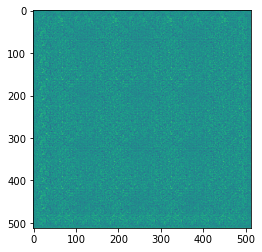

In [19]:
plt.imshow(test_out[0][0].detach().cpu())

In [18]:
test_label = discriminator(test_out)

In [19]:
test_label.shape

torch.Size([4, 1, 29, 29])

In [20]:
test_label

tensor([[[[0.3134, 0.6271, 0.6121,  ..., 0.3772, 0.4311, 0.4117],
          [0.6416, 0.1296, 0.7423,  ..., 0.2394, 0.2196, 0.4462],
          [0.4967, 0.1664, 0.4935,  ..., 0.7203, 0.3494, 0.3699],
          ...,
          [0.5889, 0.6264, 0.7554,  ..., 0.6360, 0.1677, 0.6025],
          [0.3566, 0.4237, 0.7530,  ..., 0.3648, 0.4457, 0.7916],
          [0.5974, 0.8231, 0.4690,  ..., 0.8002, 0.5865, 0.6997]]],


        [[[0.2956, 0.6082, 0.5159,  ..., 0.2998, 0.1708, 0.6896],
          [0.2443, 0.4827, 0.5432,  ..., 0.6047, 0.3377, 0.7045],
          [0.3376, 0.6999, 0.3984,  ..., 0.4875, 0.0577, 0.4143],
          ...,
          [0.6576, 0.3299, 0.6340,  ..., 0.6178, 0.2253, 0.6470],
          [0.2445, 0.5056, 0.7547,  ..., 0.7642, 0.6029, 0.6039],
          [0.3288, 0.8096, 0.4270,  ..., 0.3630, 0.3201, 0.8098]]],


        [[[0.4112, 0.4709, 0.4088,  ..., 0.4330, 0.3519, 0.3082],
          [0.4164, 0.4789, 0.2909,  ..., 0.6290, 0.3251, 0.5152],
          [0.7699, 0.4361, 0.2275,  ..